# California Housing Prices Analysis
Kevin Nolasco

Cabrini University

MCIS560 - Introduction to Machine Learning

1/23/2022

## Introduction
According to [CNBC](https://www.cnbc.com/2021/11/10/home-prices-are-now-rising-much-faster-than-incomes-studies-show.html), the prices of houses has skyrocketed during the pandemic. This issue is affecting home buyers throughout the United States. To make the home buying process easier it is important to provide home buyers accurate housing prices. In an attempt to create an accurate pricing model, we will look at California housing prices and the different features of the home to see how they affect the price.

### Approach


## Code
## Import Data

In [14]:
# import packages
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# assign paths
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# function to make directory for the housing data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# function to load the data using pandas
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# load data
fetch_housing_data()

housing_df = load_housing_data()

## Exploratory Data Analysis
What are the datatypes? How many records are there? Any Nulls?

In [5]:
# dtypes?
housing_df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Above we can see that ocean_proximity is an "object" datatype. This is pandas' way of representing a string. This means that this feature is categorical and we will need to one-hot encode it if we wish to use it in our model.

In [7]:
# record count?
n_rows, n_cols = housing_df.shape
print('This dataset contains {} rows and {} columns.'.format(n_rows, n_cols))

This dataset contains 20640 rows and 10 columns.


In [9]:
# any missing values?
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Looks like we have 207 missing records for total_bedrooms. Since that is a small fraction of the total record count we will remove those rows instead of removing the feature entirely.

In [10]:
# drop missing values
housing_df.dropna(axis = 0, inplace = True)

### Ocean Proximity Impact

I believe one of the reasons that California is a high value state is because of the beach. In this next section we will look at how the Ocean Proximity is affecting the housing prices.

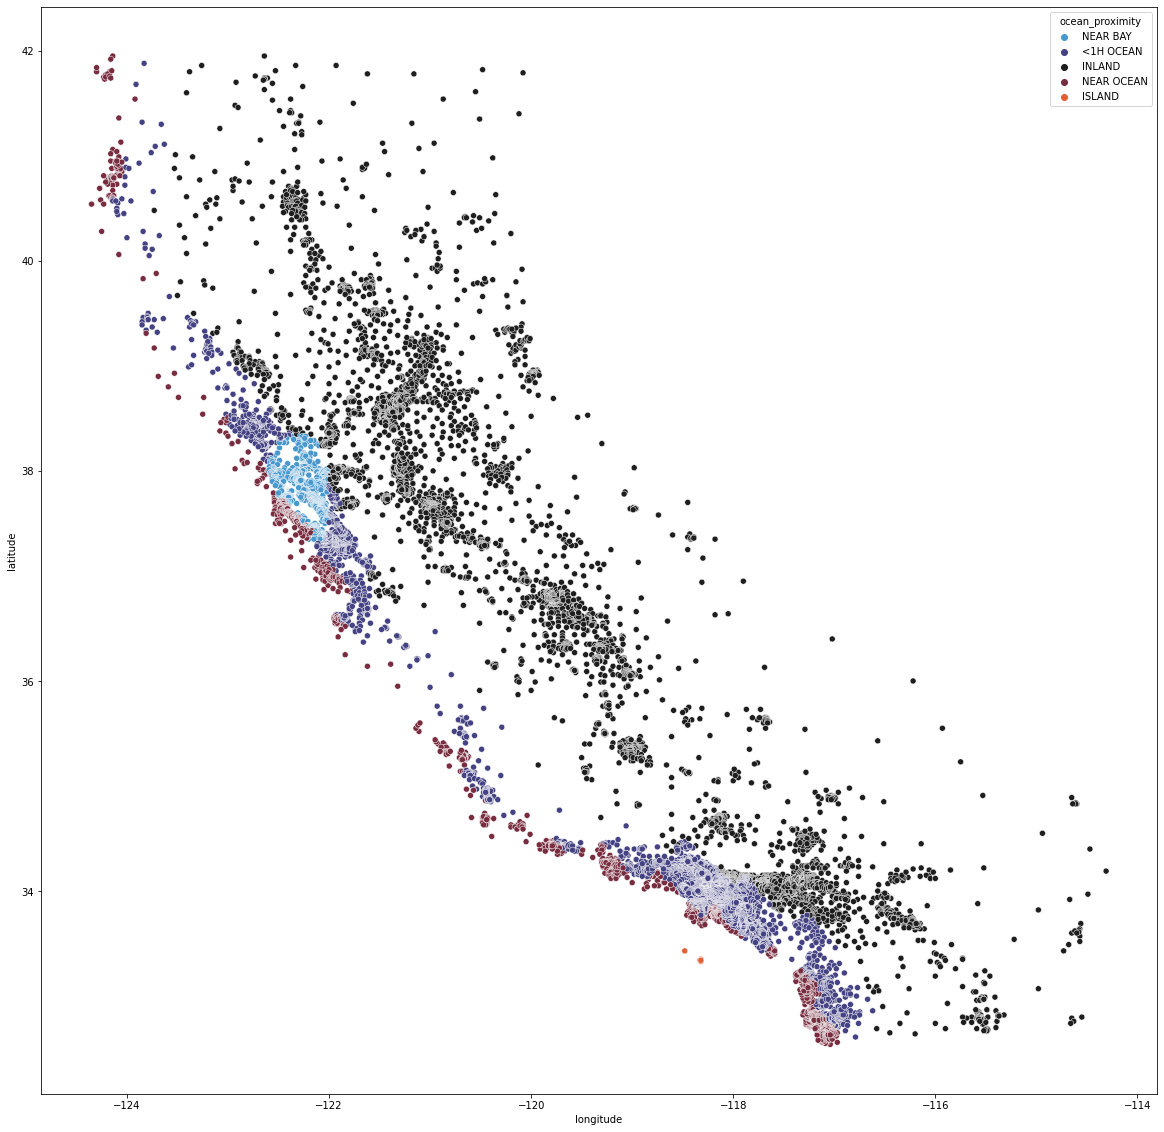

In [21]:
# visualize

fig, axs = plt.subplots(1,1)
fig.set_size_inches(20,20)

g = sns.scatterplot(data = housing_df, x = 'longitude', y = 'latitude', 
                    hue = 'ocean_proximity', palette = 'icefire', )

plt.show()